In [7]:
import pandas as pd

excel_file_path = r'Players.xlsx'

try:
    df = pd.read_excel(excel_file_path, sheet_name='Sheet1', header=0)
    print("Data loaded successfully!")
    print("Column names:", df.columns.tolist())
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{excel_file_path}' was not found.")

Data loaded successfully!
Column names: ['Player ▲', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Att_Dr', 'Succ_Dr', 'Carries', 'TotDist_Ca', 'PrgDist', 'Mis', 'Dis', 'Rec', 'Tkl', 'TklW', 'Blocks', 'Sh', 'Pass', 'Int', 'Cmp', 'Att_P', 'TotDist_C', 'PrgDist.1', 'KP', 'CrsPA']
            Player ▲   Nation    Pos        Squad                Comp  Age  \
0         Max Aarons  eng ENG  DF,MF     Valencia          es La Liga   24   
1         Max Aarons  eng ENG     DF  Bournemouth  eng Premier League   24   
2     Rodrigo Abajas   es ESP     DF     Valencia          es La Liga   21   
3     James Abankwah   ie IRL  DF,MF      Udinese          it Serie A   20   
4  Keyliane Abdallah   fr FRA     FW    Marseille          fr Ligue 1   18   

   Born  MP  Starts  Min  ...  Bloc

In [8]:
"""Clustering Forwards"""

E=df.copy()
E_FWs= E[(E["Pos"].str.contains("FW"))& (E["90s"]>1)].copy()
print(E_FWs)


               Player ▲   Nation    Pos           Squad                Comp  \
6         Himad Abdelli   dz ALG  MF,FW          Angers          fr Ligue 1   
13       Matthis Abline   fr FRA     FW          Nantes          fr Ligue 1   
15    Zakaria Aboukhlal   ma MAR  MF,FW        Toulouse          fr Ligue 1   
17        Tammy Abraham  eng ENG     FW           Milan          it Serie A   
22           Akor Adams   ng NGA     FW     Montpellier          fr Ligue 1   
...                 ...      ...    ...             ...                 ...   
2827      Anass Zaroury   ma MAR  FW,MF            Lens          fr Ligue 1   
2840      Edon Zhegrova   xk KVX  FW,MF           Lille          fr Ligue 1   
2844     Joshua Zirkzee   nl NED  FW,MF  Manchester Utd  eng Premier League   
2845    Budu Zivzivadze   ge GEO     FW      Heidenheim       de Bundesliga   
2849      Yanis Zouaoui   dz ALG  DF,FW        Le Havre          fr Ligue 1   

      Age  Born  MP  Starts   Min  ...  Blocks  Sh 

In [9]:
from sklearn.preprocessing import StandardScaler
features = ['Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'PrgC', 'PrgP', 'PrgR']
features2 = ['Gls', 'Ast', 'PK', 'CrdY', 'CrdR', 'npxG', 'xAG', 'PrgC', 'PrgP', 'PrgR']
features_attackers = [
    # Goal Scoring & Shooting
    'Gls', 'Sh', 'npxG', 'PK', 'PKatt',

    # Creativity & Passing
    'Ast', 'xAG', 'KP', 'PrgP', 'CrsPA', 'Cmp',

    # Dribbling & Ball Carrying
    'Att_Dr', 'Succ_Dr', 'PrgC',

    # Possession & Location
    'Mid 3rd', 'Att 3rd', 'Att Pen', 'Rec', 'Mis', 'Dis', 'PrgR',

    # Defensive Work-Rate
    'TklW',

    # Discipline
    'CrdY', 'CrdR'
]
X= E_FWs[features_attackers].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

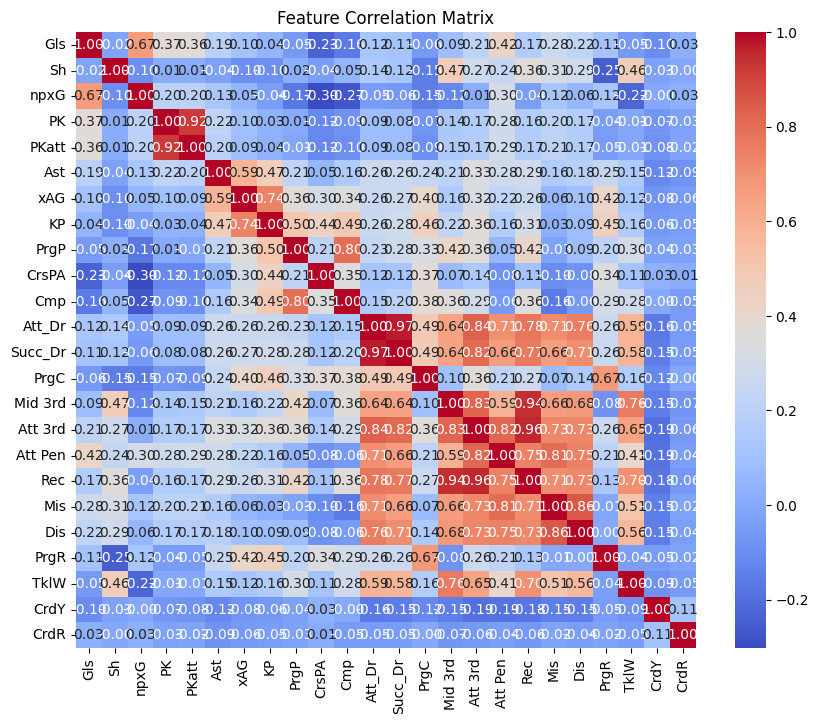

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = E_FWs[features_attackers].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

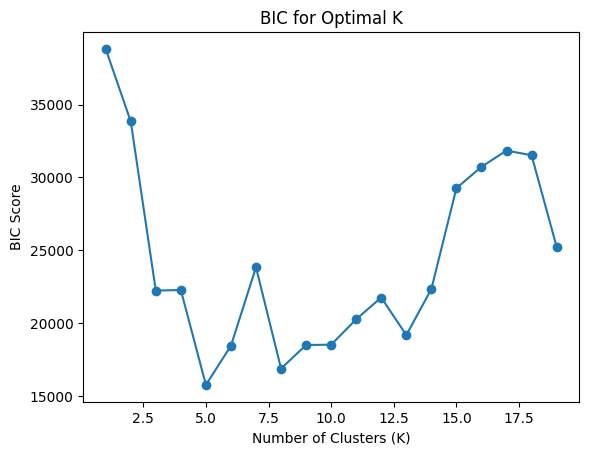

In [11]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# Test different cluster counts
n_components = range(1, 20)
bic = []
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    bic.append(gmm.bic(X_scaled))

# Plot BIC
plt.plot(n_components, bic, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('BIC Score')
plt.title('BIC for Optimal K')
plt.show()

In [12]:
gmm = GaussianMixture(n_components=8, random_state=42)
clusters = gmm.fit_predict(X_scaled)
probs = gmm.predict_proba(X_scaled)  # Probabilistic assignments

# Add clusters to DataFrame
E_FWs['Cluster'] = clusters
E_FWs['Cluster_Prob'] = np.max(probs, axis=1)  # Confidence score
cluster_profiles = E_FWs.groupby('Cluster')[features].mean()
print(cluster_profiles)


              Gls       Ast      G-PK        PK     PKatt      CrdY      CrdR  \
Cluster                                                                         
0        0.192331  0.095564  0.192331  0.000000  0.000000  0.240677  0.000000   
1        0.325714  0.208214  0.274643  0.051071  0.061429  0.115000  0.007500   
2        0.218094  0.146686  0.218094  0.000000  0.000000  0.175748  0.000000   
3        0.483810  0.196905  0.301429  0.181905  0.228095  0.148333  0.002381   
4        0.174773  0.122273  0.162273  0.012500  0.012500  0.195455  0.038864   
5        0.414815  0.119383  0.360494  0.054074  0.075926  0.167654  0.015185   
6        0.254211  0.032105  0.247895  0.006842  0.020526  0.429474  0.205263   
7        0.425517  0.259310  0.352759  0.073103  0.102414  0.125517  0.002414   

               xG      npxG       xAG      PrgC      PrgP      PrgR  
Cluster                                                              
0        0.260714  0.260714  0.132556  2.287857  

In [13]:
# Add the probability of belonging to each cluster as separate columns
for i in range(probs.shape[1]):
    E_FWs[f'Prob_Cluster_{i}'] = probs[:, i]

In [14]:
for i in sorted(E_FWs['Cluster'].unique()):
    print(f"\nCluster {i}:\n")
    display(E_FWs[E_FWs['Cluster'] == i][['Player ▲', 'Squad', 'Pos']])


Cluster 0:



,Player ▲,Squad,Pos
23,Akor Adams,Sevilla,FW
41,Jeremy Agbonifo,Lens,"FW,MF"
55,Ayman Aiki,Saint-Étienne,"FW,MF"
77,Carlos Alcaraz,Everton,"FW,MF"
81,Carles Aleñá,Getafe,"MF,FW"
...,...,...,...
2797,Erencan Yardimci,Hoffenheim,"FW,MF"
2810,Yoram Zague,Paris S-G,"DF,FW"
2817,Nicola Zalewski,Roma,"DF,FW"
2820,Nicolò Zaniolo,Atalanta,"FW,MF"



Cluster 1:



,Player ▲,Squad,Pos
103,Julián Álvarez,Atlético Madrid,FW
119,Mohamed Amoura,Wolfsburg,FW
136,Antony,Betis,FW
367,Badredine Bouanani,Nice,"MF,FW"
374,Jarrod Bowen,West Ham,"FW,MF"
468,Gianluca Caprari,Monza,"MF,FW"
675,Zuriko Davitashvili,Saint-Étienne,"FW,MF"
757,Jeremy Doku,Manchester City,"FW,MF"
825,Hugo Ekitike,Eint Frankfurt,FW
868,Abde Ezzalzouli,Betis,"FW,MF"



Cluster 2:



,Player ▲,Squad,Pos
22,Akor Adams,Montpellier,FW
29,Karim Adeyemi,Dortmund,"FW,MF"
30,Simon Adingra,Brighton,"FW,MF"
31,Amine Adli,Leverkusen,"MF,FW"
37,Oladapo Afolayan,St. Pauli,"FW,MF"
...,...,...,...
2826,Bryan Zaragoza,Osasuna,"FW,MF"
2840,Edon Zhegrova,Lille,"FW,MF"
2844,Joshua Zirkzee,Manchester Utd,"FW,MF"
2845,Budu Zivzivadze,Heidenheim,FW



Cluster 3:



,Player ▲,Squad,Pos
17,Tammy Abraham,Milan,FW
72,Chuba Akpom,Lille,FW
167,Iago Aspas,Celta Vigo,"FW,MF"
330,Mika Biereth,Monaco,FW
393,Maximilian Breunig,Heidenheim,"FW,MF"
405,Ante Budimir,Osasuna,FW
668,Lukas Daschner,Bochum,"MF,FW"
670,Jonathan David,Lille,FW
689,Romain Del Castillo,Brest,FW
698,Ermedin Demirović,Stuttgart,FW



Cluster 4:



,Player ▲,Squad,Pos
84,Alfon,Celta Vigo,"FW,MF"
184,Jordan Ayew,Leicester City,"FW,MF"
208,Mitchel Bakker,Lille,"FW,DF"
269,Sheraldo Becker,Real Sociedad,"FW,MF"
338,Tom Bischof,Hoffenheim,"MF,FW"
448,Mahdi Camara,Brest,"MF,FW"
453,Andrea Cambiaso,Juventus,"DF,FW"
461,Matteo Cancellieri,Parma,"FW,MF"
533,Pep Chavarría,Rayo Vallecano,"DF,FW"
589,Francisco Conceição,Juventus,"FW,MF"



Cluster 5:



,Player ▲,Squad,Pos
13,Matthis Abline,Nantes,FW
15,Zakaria Aboukhlal,Toulouse,"MF,FW"
24,Che Adams,Torino,FW
26,Junior Adamu,Freiburg,FW
60,Ludovic Ajorque,Brest,FW
...,...,...,...
2753,Ollie Watkins,Aston Villa,FW
2762,Danny Welbeck,Brighton,FW
2779,Jonas Wind,Wolfsburg,"FW,MF"
2788,Nick Woltemade,Stuttgart,"FW,MF"



Cluster 6:



,Player ▲,Squad,Pos
158,Jann-Fiete Arp,Holstein Kiel,"FW,MF"
179,Ezequiel Ávila,Betis,FW
433,Mathieu Cafaro,Saint-Étienne,"MF,FW"
603,Ángel Correa,Atlético Madrid,"FW,MF"
609,David Costa,Lens,"MF,FW"
639,Tomáš Čvančara,Gladbach,FW
799,Jáder Durán,Aston Villa,FW
814,Noah Edjouma,Toulouse,"MF,FW"
905,Daniel Fila,Venezia,FW
934,Ryan Fraser,Southampton,"FW,DF"



Cluster 7:



,Player ▲,Squad,Pos
6,Himad Abdelli,Angers,"MF,FW"
66,Maghnes Akliouche,Monaco,"FW,MF"
200,Alex Baena,Villarreal,"MF,FW"
238,Bradley Barcola,Paris S-G,FW
293,Eliesse Ben Seghir,Monaco,"MF,FW"
307,Álex Berenguer,Athletic Club,"FW,MF"
697,Ousmane Dembélé,Paris S-G,FW
793,Marvin Ducksch,Werder Bremen,FW
854,Sebastiano Esposito,Empoli,"FW,MF"
867,Eberechi Eze,Crystal Palace,"MF,FW"


In [15]:
player_name = "Marcus Rashford"
E_FWs.loc[E_FWs['Player ▲'] == player_name, [f'Prob_Cluster_{i}' for i in range(probs.shape[1])]]

,Prob_Cluster_0,Prob_Cluster_1,Prob_Cluster_2,Prob_Cluster_3,Prob_Cluster_4,Prob_Cluster_5,Prob_Cluster_6,Prob_Cluster_7
2181,0.000000e+00,2.041952e-90,0.0,1.000000e+00,1.316557e-119,2.863539e-45,0.0,8.319222e-133
2182,6.172715e-10,1.884141e-57,1.0,4.200385e-20,8.776955e-29,4.520861e-55,0.0,5.332945e-30


In [16]:
import os

# Create a directory to store the cluster files if it doesn't exist
output_dir = 'Europe_ATT_clusters'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each unique cluster number
for cluster_id in sorted(E_FWs['Cluster'].unique()):
    
    # Filter the DataFrame to get only the players in the current cluster
    cluster_df = E_FWs[E_FWs['Cluster'] == cluster_id][['Player ▲', 'Nation', 'Pos', 'Squad', 'Comp', 'Age','Gls', 'Ast','Cluster','Cluster_Prob']]
    
    # Define the filename for the current cluster
    file_path = os.path.join(output_dir, f'C_{cluster_id}.csv')
    
    # Save the filtered DataFrame to a CSV file
    # index=False prevents pandas from writing the DataFrame index as a column
    cluster_df.to_csv(file_path, index=False)
    
    print(f"Successfully saved Cluster {cluster_id} to {file_path}")

Successfully saved Cluster 0 to Europe_ATT_clusters\C_0.csv


Successfully saved Cluster 1 to Europe_ATT_clusters\C_1.csv
Successfully saved Cluster 2 to Europe_ATT_clusters\C_2.csv
Successfully saved Cluster 3 to Europe_ATT_clusters\C_3.csv
Successfully saved Cluster 4 to Europe_ATT_clusters\C_4.csv
Successfully saved Cluster 5 to Europe_ATT_clusters\C_5.csv
Successfully saved Cluster 6 to Europe_ATT_clusters\C_6.csv
Successfully saved Cluster 7 to Europe_ATT_clusters\C_7.csv


In [17]:
# Save the entire DataFrame, which now includes the 'Cluster' column, to a single CSV file.
E_FWs[['Player ▲', 'Nation', 'Pos', 'Squad', 'Comp', 'Age','Gls', 'Ast','Cluster','Cluster_Prob']].to_csv('all_clustered_forwards.csv', index=False)

# Or, if you prefer an Excel file:
# E_FWs.to_excel('all_clustered_midfielders.xlsx', index=False)

print("Successfully saved all clustered players to 'all_clustered_forwards.csv'")

Successfully saved all clustered players to 'all_clustered_forwards.csv'


In [20]:
# Assuming df has a 'Cluster' column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Example DataFrame (replace with your actual data)
df2 = cluster_profiles

# Normalize data (0 to 1) for each variable (column)
df_normalized = (df2 - df2.min()) / (df2.max() - df2.min())

# Number of variables
num_vars = len(df2.columns)

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Create a radar plot for each group
for group_name, row in df_normalized.iterrows():
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'polar': True})
    
    # Plot data
    values = row.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=group_name)
    ax.fill(angles, values, alpha=0.25)
    
    # Customize axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(df2.columns, size=8)
    
    # Rotate labels to avoid overlap
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        if angle < np.pi:
            label.set_ha('left')
        else:
            label.set_ha('right')
        label.set_rotation(angle * 180/np.pi - 90)
    
   
    # Add title and save
    plt.title(f'Radar Plot: {group_name}', size=12, pad=20)
    plt.tight_layout()

    output_folder = 'Europe_ATT_clusters'
    os.makedirs(output_folder, exist_ok=True)
    file_name = f'radar_{group_name}.png'
    save_path = os.path.join(output_folder, file_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
for cluster_id in sorted(E_FWs['Cluster'].unique()):
    cluster_df1 = E_FWs[E_FWs['Cluster'] == cluster_id]
    filename = f"cluster_{cluster_id}.csv"
    cluster_df1.to_csv(os.path.join('Europe_ATT_clusters', filename), index=False)

In [18]:
# Create a directory to store the cluster files if it doesn't exist
output_dir = 'Europe_ATT_clusters_private'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each unique cluster number
for cluster_id in sorted(E_FWs['Cluster'].unique()):
    
    # Filter the DataFrame to get only the players in the current cluster
    cluster_df1 = E_FWs[E_FWs['Cluster'] == cluster_id]
    
    # Define the filename for the current cluster
    file_path = os.path.join(output_dir, f'C_{cluster_id}.csv')
    
    # Save the filtered DataFrame to a CSV file
    # index=False prevents pandas from writing the DataFrame index as a column
    cluster_df1.to_csv(file_path, index=False)
    
    print(f"Successfully saved Cluster {cluster_id} to {file_path}")

Successfully saved Cluster 0 to Europe_ATT_clusters_private\C_0.csv
Successfully saved Cluster 1 to Europe_ATT_clusters_private\C_1.csv
Successfully saved Cluster 2 to Europe_ATT_clusters_private\C_2.csv
Successfully saved Cluster 3 to Europe_ATT_clusters_private\C_3.csv
Successfully saved Cluster 4 to Europe_ATT_clusters_private\C_4.csv
Successfully saved Cluster 5 to Europe_ATT_clusters_private\C_5.csv
Successfully saved Cluster 6 to Europe_ATT_clusters_private\C_6.csv
Successfully saved Cluster 7 to Europe_ATT_clusters_private\C_7.csv
